# Trainer

Before reading this note, make sure you have read the following:
* [Datasets](datasets.ipynb)
* [BERT](bert.ipynb)

The **Trainer** is the engine that drives the learning process. While the Model defines *how* to process data, the Trainer defines *how* to learn from it.

It abstracts away the repetitive boilerplate of the training loop:
1.  **Device Management:** Moving tensors to GPU/CPU.
2.  **Gradient Descent:** Computing loss, backpropagation, and weight updates.
3.  **Scheduling:** Adjusting learning rates dynamically.
4.  **Tracking:** Logging metrics and saving artifacts.


### The Training Loop

The training process follows a strict cycle for every batch of data:

1.  **Forward Pass:** Pass inputs through the Model to get predictions.
2.  **Loss Computation:** Compare predictions to targets (done by the Model).
3.  **Backward Pass:** Calculate gradients (how much each weight contributed to the error).
5.  **Optimizer Step:** Update weights.
6.  **Scheduler Step:** Control the learning rate.
7.  **Zero Gradients:** Reset gradients for the next batch.

As before, start by adding _src_ to the python system path in case your notebook is not being run with it already added.

In [1]:
import sys
from pathlib import Path
sys.path.append((Path('').resolve().parent / 'src').as_posix())

### Scheduler

Training neural nets is delicate. If we start with a high learning rate, the model diverges because the initial weights are random.
If we keep the learning rate high at the end, the model oscillates around the solution but never settles.

We use a **Warmup + Linear Decay** schedule:
1.  **Warmup:** Start at 0, increase linearly to `max_lr` over `warmup_steps`.
2.  **Decay:** Decrease linearly from `max_lr` to 0 over the rest of training.

Let's visualize this curve:

Using Python 3.13.3 environment at: /home/sergiofrayle/repos/personal/simple_bert/.venv
Audited 1 package in 1ms


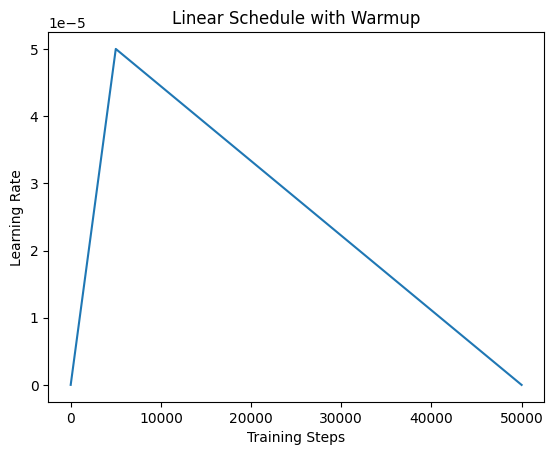

In [2]:
!uv pip install matplotlib

import matplotlib.pyplot as plt
import torch

from scheduler import BertScheduler

total_steps = 50000
warmup_steps = 5000
learning_rate = 5e-5

dummy_model = torch.nn.Linear(1, 1)

optimizer = torch.optim.AdamW(dummy_model.parameters(), lr=learning_rate)
scheduler = BertScheduler(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)


lrs = []
for _ in range(total_steps):
    optimizer.step()
    scheduler.step()
    lrs.append(scheduler.get_last_lr()[0])

plt.plot(lrs)
plt.title("Linear Schedule with Warmup")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.show()

### Tracker

Training runs can generate gigabytes of data. The _Tracker_ is responsible for organizing this.
It saves:
* **Metrics:** Loss curves, Accuracy, learning rates, etc.
* **Artifacts:** Model checkpoints (`.pt`) and config files.

It ensures that every experiment is reproducible by saving the exact configuration used.


### Full Training Setup

Now we combine everything: Model, Data, Scheduler, and Tracker into the `Trainer`. Let's use the same dummy dataset used in the [Datasets](datasets.ipynb) notes. We will start by training a Rust BPE tokenizer as we have done before. 

In [3]:
from settings import TokenizerSettings
from token_encoders.rust.bpe import RustBPETokenizer

corpus_file = Path("").resolve().parent / "data"/ "wikitext_103.txt"
text = corpus_file.read_text()

tokenizer = RustBPETokenizer(TokenizerSettings())
tokenizer.train([text])

In [4]:
from data.pretraining import NSPLabel, PretrainingDataset
from data.types.inputs.pretraining import PretrainingCorpusData
from settings import LoaderSettings

documents = [
    # Document 1: Artificial Intelligence & BERT (Logical Explanation Flow)
    [
        "BERT models are pretrained on large text corpora to understand language.",
        "They use masked language modeling to learn context from these texts.",
        "In this process, random words are hidden and the model guesses them.",
        "Next sentence prediction helps with logical coherence between clauses.",
        "This requires the model to understand if two sentences belong together.",
        "Transformer architectures rely heavily on self-attention mechanisms to do this.",
        "Attention heads allow the model to focus on different parts of a sentence.",
        "The bidirectional nature of BERT provides a deeper understanding than previous models.",
        "Fine-tuning allows these pretrained models to adapt to specific problems.",
        "Deep learning has thus revolutionized natural language processing tasks."
    ],
    # Document 2: Baking & Cooking (Chronological Steps)
    [
        "To bake a perfect cake you need fresh flour and sugar.",
        "First, mix the dry ingredients together in a large ceramic bowl.",
        "Next, whisk the eggs and butter until the mixture is smooth.",
        "Pour the wet mixture into the dry bowl and stir gently.",
        "Preheat your oven to 350 degrees before you start baking.",
        "Grease the baking pan thoroughly to prevent the cake from sticking.",
        "Pour the batter evenly into the prepared cake tin.",
        "Bake in the center of the oven for approximately thirty minutes.",
        "Insert a toothpick to check if the cake is fully cooked inside.",
        "Finally, let the cake cool on a wire rack before applying frosting."
    ],
    # Document 3: Space Exploration (Spatial Flow: Earth -> Outwards)
    [
        "Astronomy begins with observing the sky from our home planet.",
        "The moon is Earth's only natural satellite and the closest celestial body.",
        "Beyond the moon, our solar system consists of eight planets orbiting the sun.",
        "Mars is the next target for human exploration due to its proximity.",
        "Future missions aim to land humans on the Red Planet within a decade.",
        "Further out, gas giants like Saturn display spectacular ring systems.",
        "Our sun is just one of billions of stars in the Milky Way galaxy.",
        "Stars are born in giant clouds of gas and dust called nebulae.",
        "When massive stars die, they can collapse into black holes.",
        "The universe is vast, expanding, and filled with infinite mysteries."
    ],
    # Document 4: Oceanography (Depth Flow: Surface -> Deep Sea)
    [
        "The ocean covers more than seventy percent of the Earth's surface.",
        "The surface is shaped by tides caused by the moon's gravity.",
        "Ocean currents regulate the global climate by transporting this heat.",
        "Just below the surface, plankton serves as the base of the food web.",
        "Coral reefs thrive in these shallow waters, hosting diverse ecosystems.",
        "Larger animals like whales migrate thousands of miles through these waters.",
        "As we go deeper, sunlight fades and the water becomes much colder.",
        "Deep sea trenches contain some of the most mysterious creatures on Earth.",
        "Many species in this dark abyss generate their own light through bioluminescence.",
        "Exploring this ocean floor is as difficult as exploring outer space."
    ],
    # Document 5: History of Civilization (Chronological Timeline)
    [
        "Early humans lived as hunter-gatherers, moving constantly to find food.",
        "The discovery of agriculture allowed these groups to settle in one place.",
        "Settlements grew into cities, requiring new ways to organize society.",
        "Ancient civilizations like Egypt developed writing to record their history.",
        "Later, the Greek empire laid the foundation for Western philosophy and democracy.",
        "The Roman Empire expanded these ideas across a vast network of roads.",
        "After Rome fell, the Middle Ages brought a period of feudalism.",
        "The Renaissance later sparked a rebirth of art, science, and exploration.",
        "The Industrial Revolution eventually changed how humans lived and worked forever.",
        "Today, we live in a globalized world connected by digital technology."
    ]
]

corpus_data = PretrainingCorpusData(documents=[10*d for d in documents])
LOADER_SETTINGS = LoaderSettings(batch_size=2, num_workers=2)
dataset = PretrainingDataset(corpus_data, tokenizer, LOADER_SETTINGS)
print(f"Dataset Initialized. Total samples available: {len(dataset)}\n")

Dataset Initialized. Total samples available: 500



Now let's define the rest of the pieces we need:

In [5]:
from modules.bert.pretraining import BertForPreTraining
from settings import BertSettings,PreTrainingSettings, TrackerSettings
from trainers.pretraining import PreTrainer
from tracker import ExperimentTracker

TRAINER_SETTINGS = PreTrainingSettings(
    warmup_steps=1000,
    total_steps=10000,
    log_interval_steps=500,
    save_interval_steps=1000,
)
BERT_SETTINGS = BertSettings(hidden_size=96, num_hidden_layers=4, num_attention_heads=6)

model = BertForPreTraining(BERT_SETTINGS)

trainer = PreTrainer(
    model=model,
    train_dataset=dataset,
    settings=TRAINER_SETTINGS,
    tracker=ExperimentTracker(
        TrackerSettings(), [LOADER_SETTINGS, TRAINER_SETTINGS, BERT_SETTINGS]
    ),
)

### Running the Trainer

Calling `train()` executes the loop. The tracker will automatically save checkpoints and metrics to disk. We will be running several thousand steps with batch size 2 on this dummy dataset with a tiny Bert model. Do not expect results to be good of course. 

In [6]:
trainer.train()

Pretraining:   0%|                                                                                                                                                  | 0/10000 [00:00<?, ?it/s]

/home/sergiofrayle/repos/personal/simple_bert/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Pretraining: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [1:27:43<00:00,  1.90it/s, loss=7.0955e+00, lr=0.0000e+00]


### Inspecting Artifacts

Let's verify that the Tracker successfully saved our model, settings and metrics.

In [7]:
!tree {trainer.tracker.run_dir}

runs/exp_2026-02-21_19:37:21
├── checkpoints
│   ├── best.pt
│   └── last.pt
├── settings.json
└── tensorboard
    └── events.out.tfevents.1771699041.t14-pf4f4t2m.58712.0

3 directories, 4 files


Launch the tensorbaord to inspect results and see if training loss is going down.

In [8]:
%load_ext tensorboard
%tensorboard --logdir {trainer.tracker.run_dir} --bind_all